In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance

EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [56]:
# Reading the dataset
data = pd.read_csv("dataset/Job_Change/aug_train.csv")
aug_train = data.sample(frac=1, replace=True, random_state=1).reset_index(drop=True)

# Seperate aug_train into target and features 
y = aug_train['target']
X_aug_train = aug_train.drop('target',axis = 'columns')
# save the index for X_aug_train 
X_aug_train_index = X_aug_train.index.to_list()

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                # convert float NaN --> string NaN
                output[col] = output[col].fillna('NaN')
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# store the catagorical features names as a list      
cat_features = X_aug_train.select_dtypes(['object']).columns.to_list()

# use MultiColumnLabelEncoder to apply LabelEncoding on cat_features 
# uses NaN as a value , no imputation will be used for missing data
X = MultiColumnLabelEncoder(columns = cat_features).fit_transform(X_aug_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

print("Train data: ", X_train.shape)
print("Test data: ", X_test.shape)

Train data:  (13410, 13)
Test data:  (5748, 13)


In [57]:
y_train.value_counts()

0.0    9945
1.0    3465
Name: target, dtype: int64

In [58]:
y_test.value_counts()

0.0    4338
1.0    1410
Name: target, dtype: int64

# Default Model

In [59]:
model_default = svm.SVC(kernel='sigmoid')
scores_default = cross_val_score(model_default, X=X_train, y=y_train, cv = FOLDS)
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)
get_performance(X_test, y_test, y_pred_default)

Performance on all data
Precision: 0.6276959352355325
Recall: 0.6240431454418929
F1 Score: 0.6258444553933447


(0.6276959352355325, 0.6240431454418929, 0.6258444553933447, None)

In [60]:
pd.DataFrame(y_pred_default).value_counts()

0.0    4297
1.0    1451
dtype: int64

# SMOTE Oversampling

In [61]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
model_SMOTE = svm.SVC()
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)
get_performance(X_test, y_test, y_pred_SMOTE)

Performance on all data
Precision: 0.6538418795365535
Recall: 0.4897355601948504
F1 Score: 0.5219292298532587


(0.6538418795365535, 0.4897355601948504, 0.5219292298532587, None)

In [62]:
print(X_train_sm.shape,y_train_sm.shape)

(19890, 13) (19890,)


# MAPS

In [63]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [64]:
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

In [65]:
def mispredict_label(row):
    if row['target'] == row['pred']:
        return False
    return True

In [66]:
default_result_copy = default_result.copy()
X_test_copy = X_test.copy()
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)

In [67]:
# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Generate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target)

print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

MMD Spent: 2.206320285797119 BGMD Spent: 1.5731756687164307


([[0.5735882614495331, 'enrollee_id>6616'],
  [0.5523877405559515, 'enrollee_id<=19841'],
  [0.43633071816535907, 'enrollee_id<=13389 & enrollee_id>6616']],
 [[0.5735882614495331, 'enrollee_id>6616'],
  [0.5523877405559515, 'enrollee_id<=19841'],
  [0.43633071816535907, 'enrollee_id<=13389 & enrollee_id>6616']])

In [68]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['target'])

In [69]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 101)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
    print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=upweight)

    c = Counter(weights)
    print(c.items())

    MAPS_model = svm.SVC(kernel='sigmoid')
    scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
    MAPS_model.fit(X_train, y_train, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0])
    recall_all.append(total_result[1])
    f1_all.append(total_result[2])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, average='weighted')
    acc_mispredicted.append(MAPS_MD_metric[0])
    recall_mispredicted.append(MAPS_MD_metric[1])
    f1_mispredicted.append(MAPS_MD_metric[2])
    
    if total_result[2] > best_f1_all:
        best_f1_all = total_result[2]
        best_weight_all = upweight;
    if MAPS_MD_metric[2] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2]
        best_weight_mis = upweight

Upweight_value:  1
dict_items([(1, 13410)])
Performance on all data
Precision: 0.6276959352355325
Recall: 0.6240431454418929
F1 Score: 0.6258444553933447
Upweight_value:  2
dict_items([(2, 13410)])
Performance on all data
Precision: 0.6276201741273549
Recall: 0.6235212247738344
F1 Score: 0.6255391511795259
Upweight_value:  3
dict_items([(3, 13410)])
Performance on all data
Precision: 0.6276201741273549
Recall: 0.6235212247738344
F1 Score: 0.6255391511795259
Upweight_value:  4
dict_items([(4, 13410)])
Performance on all data
Precision: 0.6276201741273549
Recall: 0.6235212247738344
F1 Score: 0.6255391511795259
Upweight_value:  5
dict_items([(5, 13410)])
Performance on all data
Precision: 0.6278804315183474
Recall: 0.6236951983298539
F1 Score: 0.6257548449534425
Upweight_value:  6
dict_items([(6, 13410)])
Performance on all data
Precision: 0.6277964092546943
Recall: 0.6235212247738344
F1 Score: 0.6256244459155706
Upweight_value:  7
dict_items([(7, 13410)])
Performance on all data
Precisio

Upweight_value:  54
dict_items([(54, 13410)])
Performance on all data
Precision: 0.6278965395334526
Recall: 0.622999304105776
F1 Score: 0.625402808791976
Upweight_value:  55
dict_items([(55, 13410)])
Performance on all data
Precision: 0.6278965395334526
Recall: 0.622999304105776
F1 Score: 0.625402808791976
Upweight_value:  56
dict_items([(56, 13410)])
Performance on all data
Precision: 0.6278965395334526
Recall: 0.622999304105776
F1 Score: 0.625402808791976
Upweight_value:  57
dict_items([(57, 13410)])
Performance on all data
Precision: 0.6278965395334526
Recall: 0.622999304105776
F1 Score: 0.625402808791976
Upweight_value:  58
dict_items([(58, 13410)])
Performance on all data
Precision: 0.6278965395334526
Recall: 0.622999304105776
F1 Score: 0.625402808791976
Upweight_value:  59
dict_items([(59, 13410)])
Performance on all data
Precision: 0.6278965395334526
Recall: 0.622999304105776
F1 Score: 0.625402808791976
Upweight_value:  60
dict_items([(60, 13410)])
Performance on all data
Precis

Best weight on all is:  7
Best weight on misprediction area is:  7


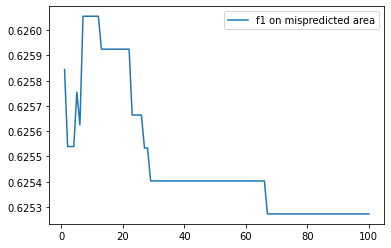

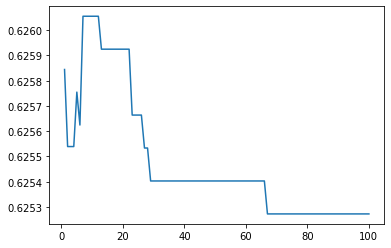

In [70]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.show()

In [71]:
from helper import get_mispredicted_region_test

weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=best_weight_mis)
c = Counter(weights)
MAPS_model = svm.SVC(kernel='sigmoid')
scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
MAPS_model.fit(X_train, y_train, sample_weight = weights)
y_pred_MAPS = MAPS_model.predict(X_test)
get_performance(X_test, y_test, y_pred_MAPS)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='target')

Performance on all data
Precision: 0.6283165065227811
Recall: 0.6238691718858733
F1 Score: 0.6260554649325664
y_actual_MD: 5748
y_predict_default_MD: 5748
y_pred_SMOTE_MD: 5748
y_pred_MAPS_MD: 5748

Default: (0.6276959352355325, 0.6240431454418929, 0.6258444553933447, None)
SMOTE: (0.6538418795365535, 0.4897355601948504, 0.5219292298532587, None)
MAPS: (0.6283165065227811, 0.6238691718858733, 0.6260554649325664, None)


In [72]:
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
out.to_csv('MAPS_Job_Change.csv')

# Just Train Twice

In [73]:
from helper import generate_JTT_Weights

In [74]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 29)

model_JTT = svm.SVC(kernel='sigmoid')
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)
get_performance(X_val, y_val, y_pred_JTT_val)

Performance on all data
Precision: 0.6211635492502586
Recall: 0.622232263895165
F1 Score: 0.621695288478734


(0.6211635492502586, 0.622232263895165, 0.621695288478734, None)

In [75]:
grid_upweights_JTT = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
f1_all_JTT = [];

for upweight in grid_upweights_JTT:
    weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = svm.SVC(kernel='sigmoid')
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    f1_all_JTT.append(total_result_JTT[2])
    if total_result_JTT[2] > best_f1_all_JTT:
        best_f1_all_JTT = total_result_JTT[2]
        best_weight_all_JTT = upweight;

Performance on all data
Precision: 0.627578251849162
Recall: 0.6252609603340292
F1 Score: 0.6264095071240023
Performance on all data
Precision: 0.6279159389747377
Recall: 0.6259568545581071
F1 Score: 0.6269291517395285
Performance on all data
Precision: 0.6325292673580595
Recall: 0.6991997216423104
F1 Score: 0.6555695884105919
Performance on all data
Precision: 0.6321352904149223
Recall: 0.7004175365344468
F1 Score: 0.6555002942329714
Performance on all data
Precision: 0.632950747351734
Recall: 0.7018093249826026
F1 Score: 0.6562299886971464
Performance on all data
Precision: 0.6336536569243627
Recall: 0.703375086986778
F1 Score: 0.6568936017542432
Performance on all data
Precision: 0.6340741455359923
Recall: 0.7038970076548364
F1 Score: 0.657231850311085
Performance on all data
Precision: 0.6329731594084412
Recall: 0.7035490605427975
F1 Score: 0.6564732323534822
Performance on all data
Precision: 0.6339617792586933
Recall: 0.7047668754349339
F1 Score: 0.65726021179864
Performance on a

JTT Best weight on all is:  200
JTT Best f1 score on all:  0.6579109784785071


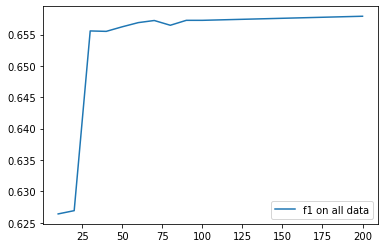

In [76]:
print("JTT Best weight on all is: ", best_weight_all_JTT)
print("JTT Best f1 score on all: ", best_f1_all_JTT)
plt.plot(grid_upweights_JTT, f1_all_JTT, label = "f1 on all data")
plt.legend()
plt.show()

In [77]:
weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = best_weight_all_JTT)
    
#combine train and validate data
weights = np.concatenate((np.ones(len(X_train_1st)), weights))
y_train_2nd = np.concatenate((y_train_1st, y_val))
X_train_2nd = pd.concat([X_train_1st, X_val])
X_train_2nd['val_weight'] = weights
X_train_2nd['target'] = y_train_2nd
X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
weights = X_train_2nd['val_weight'].to_list()
y_train_2nd = X_train_2nd['target']
X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)

model_JTT = svm.SVC(kernel='sigmoid')
scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
y_pred_JTT = model_JTT.predict(X_test)
total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_JTT, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='target')

Performance on all data
Precision: 0.6347053382560773
Recall: 0.7063326374391092
F1 Score: 0.6579109784785071
y_actual_MD: 5748
y_predict_default_MD: 5748
y_pred_SMOTE_MD: 5748
y_pred_MAPS_MD: 5748

Default: (0.6347053382560773, 0.7063326374391092, 0.6579109784785071, None)
SMOTE: (0.6538418795365535, 0.4897355601948504, 0.5219292298532587, None)
MAPS: (0.6283165065227811, 0.6238691718858733, 0.6260554649325664, None)
